#### Advanced text classifier using 1D CNN

#### 1. Installs
- Need to force a reinstall of torch (version 2.3) to enable the compatible torchtext package installation
- Then install torchtext (version 0.18.0)
- Then install torchdata (version 0.9.0)
- This will then uninstall a number of standard packages such as numpy, tqdm etc
- Finally a restart of the session will be required

In [1]:
!pip install --force-reinstall torch==2.3.0 torchtext==0.18.0 portalocker torchdata==0.9.0


  Using cached torch-2.3.0-cp312-cp312-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torchtext-0.18.0-cp312-cp312-manylinux1_x86_64.whl.metadata (7.9 kB)
  Using cached portalocker-3.2.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached torchdata-0.9.0-cp312-cp312-manylinux1_x86_64.whl.metadata (5.5 kB)
  Using cached filelock-3.24.2-py3-none-any.whl.metadata (2.0 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2026.2.0-py3-none-any.whl.metadata (10 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
 

### 2. Mount my Google Colab drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 2. Imports

In [2]:
import torch
import torchtext
import torchdata
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import pandas as pd
import sys, os
from timeit import default_timer as timer

/usr/local/lib/python3.12/dist-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext i

In [3]:
print(f"Torch packages versions:")
print(f"torch.__version__: {torch.__version__}")
print(f"torchtext.__version__: {torchtext.__version__}")
print(f"torchdata.__version__: {torchdata.__version__}")

Torch packages versions:
torch.__version__: 2.3.0+cu121
torchtext.__version__: 0.18.0+cpu
torchdata.__version__: 0.9.0+cpu


#### 3. Configuration specification

In [4]:
WORKING_FOLDER_PATH = "/content/drive/MyDrive/Ade-Colab-Notebooks/AI-Thursdays/Language-Models/CNN-Model-Solutions"
sys.path.insert(1, f"{WORKING_FOLDER_PATH}/modules")
import configs_advanced as cfg

config = cfg.Config()

In [5]:
config.random_state

100

#### 4. Load IMDB Dataset

In [6]:
import text_processing as tp

# vocab, train_iter, test_iter = tp.compute_vocabulary(config)
vocab, train_df, test_df = tp.compute_vocabulary(config)

In [7]:
vocab_size = len(vocab)
sample_vocab_tokens = vocab.get_itos()[:10]
print(f"Vocab size: {vocab_size}")
print(f"Sample vocab tokens: {sample_vocab_tokens}")


Vocab size: 20000
Sample vocab tokens: ['<pad>', '<unk>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'"]


#### 5. Text Encoding + Dataset Class

In [8]:
tp.check_labels(train_df)
tp.check_labels(test_df)
full_train_dataset_df = tp.create_data_table(train_df)
test_dataset_df = tp.create_data_table(test_df)


Counter items: dict_items([('negative', 4918), ('positive', 5082)])
Counter items: dict_items([('positive', 19918), ('negative', 20082)])


##### Sample the "train" dataset

In [9]:
full_train_dataset_df.to_csv(config.train_valid_dataset_path, index=False)
full_train_dataset_df.head()

,sentiment,review
0,0,This is a documentary about homeless women. It...
1,0,"Not well done at all, the whole movie was just..."
2,0,It's strange what fate does to some people. Wh...
3,1,And that goes especially for lawyers & cops. P...
4,1,"First, an explanation: Despite my headline, I'..."


##### Sample IMDB "test" dataset

In [10]:
unique_labels = test_dataset_df["sentiment"].unique()
print(f"\nunique_labels: {unique_labels}\n\n")
test_dataset_df.to_csv(config.test_dataset_path, index=False)
test_dataset_df.head()



unique_labels: [1 0]




,sentiment,review
0,1,One of the other reviewers has mentioned that ...
1,1,A wonderful little production. <br /><br />The...
2,1,I thought this was a wonderful way to spend ti...
3,0,Basically there's a family where a little boy ...
4,1,"Petter Mattei's ""Love in the Time of Money"" is..."


#### Create IMDB Dataset

In [11]:
import IMDBDataset as ds
full_train_dataset = ds.IMDBDataset(full_train_dataset_df, config, vocab)
test_dataset = ds.IMDBDataset(test_dataset_df, config, vocab)

#### 6. Train / Validation Split

In [12]:
train_size = int(config.train_fraction_split * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size]
)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=True)


##### Sample "train" dataloader

In [13]:
from utils import sample_dataloader

sample_dataloader(train_loader)

inputs.shape: torch.Size([64, 500])
labels.shape: torch.Size([64])
labels[:n_samples]: tensor([0., 0., 0., 0., 1.])
inputs[:n_samples]: tensor([[11885,    56,   192,  ...,     0,     0,     0],
        [   54,    55,    36,  ...,     0,     0,     0],
        [    5,   557,     7,  ...,  2783,    25,    47],
        [    2,  3118,    10,  ...,     0,     0,     0],
        [  145,    14,    23,  ...,     0,     0,     0]])

inputs.shape: torch.Size([64, 500])
labels.shape: torch.Size([64])
labels[:n_samples]: tensor([0., 0., 1., 0., 0.])
inputs[:n_samples]: tensor([[   13,    17,   285,  ...,     0,     0,     0],
        [   14,    10,   239,  ...,     0,     0,     0],
        [  274,    13,    17,  ...,     0,     0,     0],
        [ 7888,     7, 19854,  ...,     0,     0,     0],
        [  207,     5,   837,  ...,     0,     0,     0]])



##### Sample "test" dataloader

In [14]:
sample_dataloader(val_loader)

inputs.shape: torch.Size([64, 500])
labels.shape: torch.Size([64])
labels[:n_samples]: tensor([0., 1., 1., 0., 0.])
inputs[:n_samples]: tensor([[  244,    21,  2255,  ...,     0,     0,     0],
        [    1, 17347,     9,  ...,     0,     0,     0],
        [    2,    23,    17,  ...,     0,     0,     0],
        [  785,     2,  6657,  ...,   608,   304,     3],
        [  626,     8,   136,  ...,     0,     0,     0]])

inputs.shape: torch.Size([64, 500])
labels.shape: torch.Size([64])
labels[:n_samples]: tensor([0., 0., 0., 1., 1.])
inputs[:n_samples]: tensor([[18427,  2576,    27,  ...,     0,     0,     0],
        [   14,     1,   710,  ...,     0,     0,     0],
        [   13,   216,    14,  ...,     0,     0,     0],
        [   14,    10,   223,  ...,     0,     0,     0],
        [   14,    19,    10,  ...,     0,     0,     0]])



#### 7. CNN Model (Equivalent to Keras Model)

In [16]:
from advanced_text_cnn import AdvancedTextCNN

#### 8. Training + Validation Loop

In [17]:
from advanced_text_classifer import AdvancedTextClassifier

# config.is_use_pretrained_model = False

start = timer()
model = AdvancedTextCNN(vocab).to(config.device)
if config.is_use_pretrained_model and os.path.exists(config.model_advanced_cnn_path):
   model.load_state_dict(torch.load(config.model_advanced_cnn_path))
else:
  classifier = AdvancedTextClassifier(
      model=model,
      train_loader=train_loader,
      val_loader=val_loader
  )
  model = classifier.run_train_validation_cycle()

end = timer()
elapsed_time_seconds = end - start
elapsed_time_mins = elapsed_time_seconds / 60
print(f"\n\nTraining/validation time taken: {elapsed_time_seconds: .2f} (secs) / {elapsed_time_mins: .2f} (mins)")
print(f"{config.line_divider}{config.next_line}")


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 125/125 [01:12<00:00,  1.72it/s]



Epoch 1/20
Train Loss: 0.7063
Val Loss: 0.5210 | Val Acc: 0.7590


100%|██████████| 125/125 [01:18<00:00,  1.58it/s]



Epoch 2/20
Train Loss: 0.5372
Val Loss: 0.4312 | Val Acc: 0.8145


100%|██████████| 125/125 [01:19<00:00,  1.57it/s]



Epoch 3/20
Train Loss: 0.4668
Val Loss: 0.3849 | Val Acc: 0.8410


100%|██████████| 125/125 [01:17<00:00,  1.61it/s]



Epoch 4/20
Train Loss: 0.4056
Val Loss: 0.3440 | Val Acc: 0.8510


100%|██████████| 125/125 [01:24<00:00,  1.48it/s]



Epoch 5/20
Train Loss: 0.3376
Val Loss: 0.3377 | Val Acc: 0.8580


100%|██████████| 125/125 [01:15<00:00,  1.65it/s]



Epoch 6/20
Train Loss: 0.2661
Val Loss: 0.3138 | Val Acc: 0.8655


100%|██████████| 125/125 [01:16<00:00,  1.63it/s]



Epoch 7/20
Train Loss: 0.2111
Val Loss: 0.3174 | Val Acc: 0.8690


100%|██████████| 125/125 [01:17<00:00,  1.61it/s]



Epoch 8/20
Train Loss: 0.1572
Val Loss: 0.3356 | Val Acc: 0.8605


100%|██████████| 125/125 [01:14<00:00,  1.67it/s]



Epoch 9/20
Train Loss: 0.1131
Val Loss: 0.3893 | Val Acc: 0.8640
Early stopping triggered.


Training/validation time taken:  768.91 (secs) /  12.82 (mins)



9. Test Prediction

In [18]:
def predict(model):
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.to(config.device)
          outputs = model(inputs)

          preds = (outputs >= 0.5).cpu().numpy()
          all_preds.extend(preds)
          all_labels.extend(labels.numpy())

  all_preds = np.array(all_preds)
  all_labels = np.array(all_labels)
  return all_preds, all_labels

all_preds, all_labels = predict(model)

#### 10. Report classifier performance (Classification Report & Confusion Matrix)

classification_report:               precision    recall  f1-score   support

         0.0     0.8111    0.9034    0.8548     20082
         1.0     0.8900    0.7879    0.8358     19918

    accuracy                         0.8459     40000
   macro avg     0.8506    0.8457    0.8453     40000
weighted avg     0.8504    0.8459    0.8454     40000



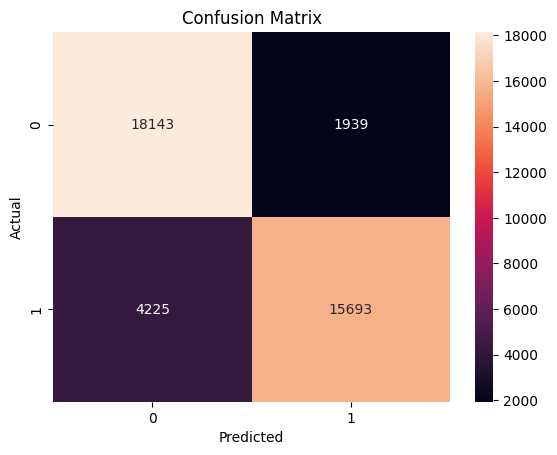

In [19]:
def evaluate_model_performance(all_labels, all_preds):
  class_report = classification_report(all_labels, all_preds, digits=4)
  cm = confusion_matrix(all_labels, all_preds)

  print(f"classification_report:\n{class_report}")
  plt.figure()
  sns.heatmap(cm, annot=True, fmt="d")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

evaluate_model_performance(all_labels, all_preds)